Загружаем зависимости

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


Загружаем данные

In [96]:
data = pd.read_csv('../contest1/train.csv')
data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


Удаляем все дубликаты и null из данных

In [97]:
transformed_data = data.drop_duplicates()
transformed_data['EmploymentStatus'] = transformed_data['EmploymentStatus'].fillna(value='Employed')
transformed_data['MaritalStatus'] = transformed_data['MaritalStatus'].fillna(value='Single')
transformed_data = transformed_data.dropna()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7592\421684985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_data['EmploymentStatus'] = transformed_data['EmploymentStatus'].fillna(value='Employed')
C:\Users\Ivan\AppData\Local\Temp\ipykernel_7592\421684985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_data['MaritalStatus'] = transformed_data['MaritalStatus'].fillna(value='Single')


Посмотрим на то, как распределяется наш risk score

<Axes: ylabel='Frequency'>

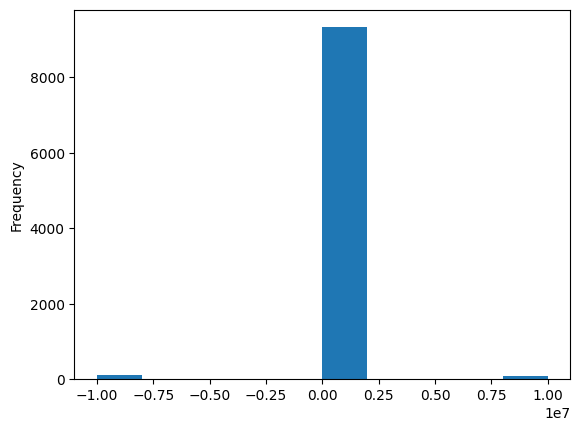

In [98]:
transformed_data['RiskScore'].plot.hist()

Не очень похоже на правду из-за сильно выбивающихся значений, уберём их и попробуем ещё раз

<Axes: ylabel='Frequency'>

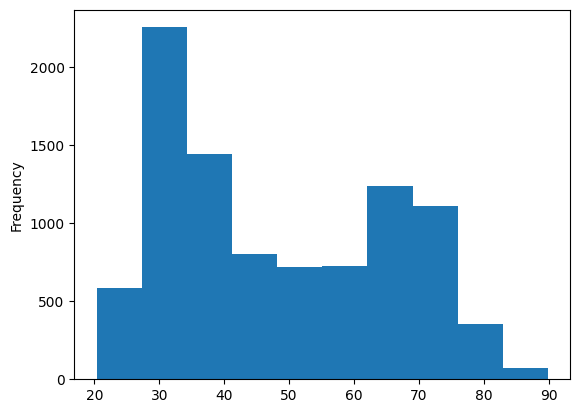

In [99]:
quatile_low, quantile_high = [
  transformed_data['RiskScore'].quantile(q=0.013),
  transformed_data['RiskScore'].quantile(q=0.99),
]

transformed_data = transformed_data[
  transformed_data['RiskScore'].between(quatile_low, quantile_high)
]

transformed_data['RiskScore'].plot.hist()

Теперь больше похоже на правду

Следующим шагом замаппим нечисловые значения в числовые

Было:

In [100]:
for column in data.select_dtypes(include=['object']).columns:
    print(f'{column}: {data[column].unique()}')

ApplicationDate: ['2010-06-26' '1996-09-23' '2015-01-19' ... '2010-11-07' '2001-12-28' nan]
MaritalStatus: ['Divorced' 'Widowed' 'Married' 'Single' nan]
HomeOwnershipStatus: ['Rent' 'Mortgage' 'Other' 'Own' nan]
LoanPurpose: ['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other' nan]
EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed' nan]
EducationLevel: ['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate' nan]


In [101]:
transformed_data = transformed_data.copy()
transformed_data.drop(['ApplicationDate'], axis=1, inplace=True)

def transform_object_columns(dataframe):
  for column in dataframe.select_dtypes(include=['object']).columns:
    dataframe[column] = TargetEncoder().fit_transform(
      dataframe[column].values.reshape(-1, 1),
      dataframe[column].values
    )
  
  return dataframe

transform_object_columns(transformed_data)

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1.0,0.0,1095.0,0.151985,...,1.0,1.0,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,55.0,172147.0,850.0,16110.0,36.0,0.0,1.0,1.0,211.0,0.175693,...,1.0,0.0,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,51.0,300000.0,850.0,38436.0,36.0,0.0,0.0,1.0,546.0,0.444605,...,1.0,0.0,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,25.0,34683.0,847.0,19186.0,48.0,0.0,0.0,0.0,153.0,0.188452,...,1.0,0.0,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,55.0,300000.0,850.0,30437.0,48.0,0.0,2.0,0.0,562.0,0.273431,...,1.0,0.0,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,31.0,300000.0,850.0,14503.0,60.0,0.0,2.0,1.0,185.0,0.056431,...,1.0,0.0,10.0,6992.0,0.104503,0.113622,317.956385,0.020118,1.0,34.037970
9995,27.0,15000.0,361.0,19505.0,36.0,0.0,1.0,0.0,622.0,0.409411,...,1.0,0.0,2.0,31346.0,0.334005,0.346203,878.142786,1.200114,0.0,76.185933
9996,49.0,185082.0,573.0,7447.0,84.0,0.0,0.0,1.0,946.0,0.095426,...,1.0,0.0,27.0,14016.0,0.255947,0.235055,181.438855,0.073099,1.0,41.213393
9997,55.0,296728.0,850.0,44162.0,84.0,1.0,2.0,1.0,479.0,0.373804,...,1.0,0.0,33.0,3624.0,0.154162,0.144973,839.774585,0.053333,1.0,43.699684


Стало:

In [102]:
for column in transformed_data[[
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose',
    'EmploymentStatus',
    'EducationLevel',
]].columns:
    print(f'{column}: {transformed_data[column].unique()}')

MaritalStatus: [1. 0.]
HomeOwnershipStatus: [0. 1.]
LoanPurpose: [0. 1.]
EmploymentStatus: [1. 0.]
EducationLevel: [1. 0.]


Посмотрим на корелляционнцю матрицу и удалим признаки, которые сильно коррелируют

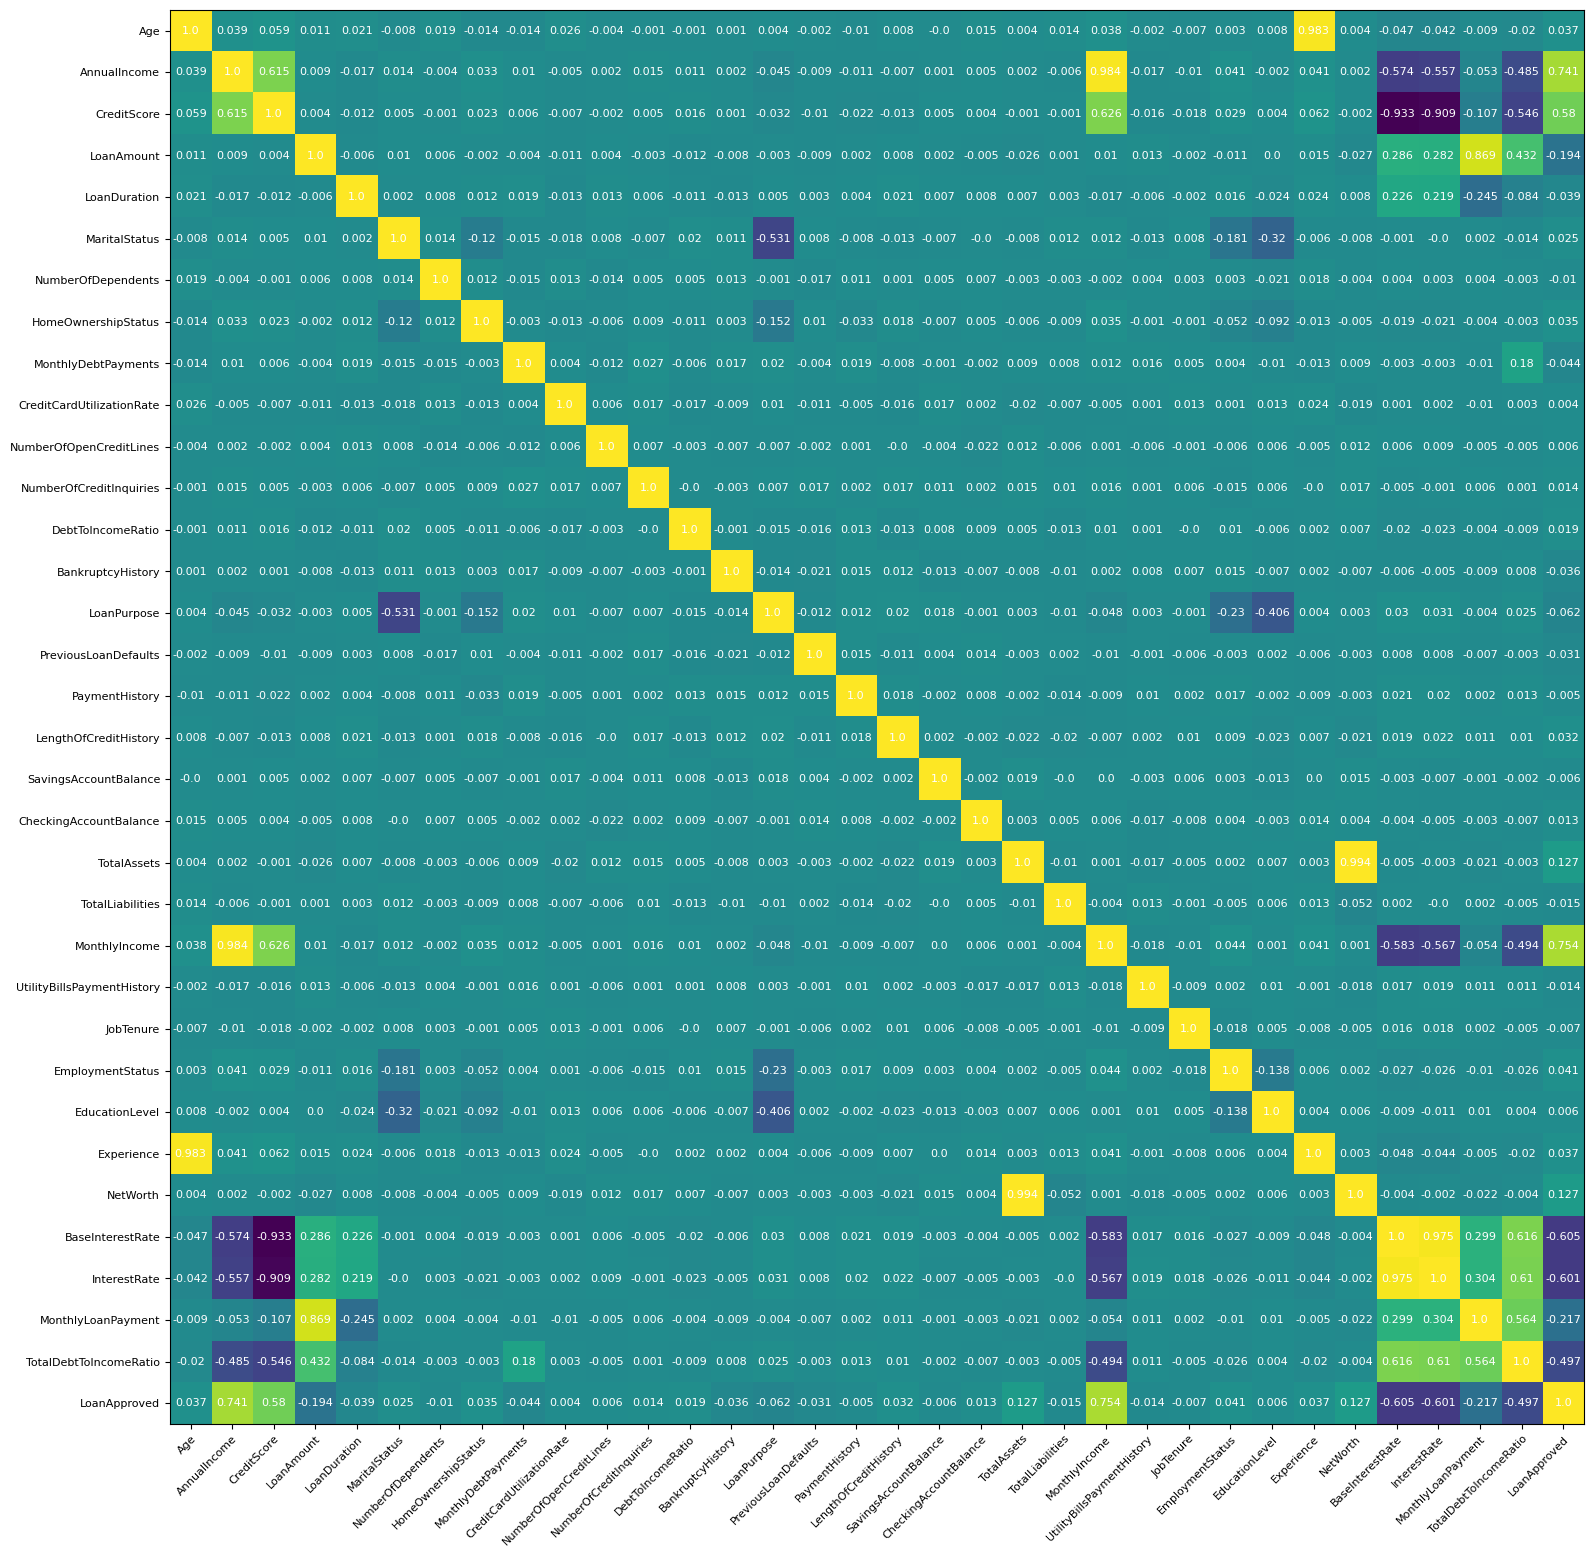

In [103]:
up_for_transformation = transformed_data.copy(True)
correlation = up_for_transformation.drop(['RiskScore'], axis=1).corr()

fig, ax = plt.subplots()
im = ax.imshow(correlation)

fig.set_figwidth(16)
fig.set_figheight(16)

ax.set_xticks(
  np.arange(len(correlation.columns)),
  correlation.columns,
  fontsize=8,
  rotation=45,
  ha="right",
  rotation_mode="anchor")
ax.set_yticks(
  np.arange(len(correlation.columns)),
  correlation.columns,
  fontsize=8
)

for i in range(len(correlation.columns)):
  for j in range(len(correlation.columns)):
    ax.text(
      i, j, correlation[correlation.columns[i]][correlation.columns[j]].round(3), ha="center", va="center", color="w", fontdict={'size': 8}
    )

fig.tight_layout()
plt.show()

Отсюда видно, что можно удалить ['BaseInterestRate', 'Experience', 'TotalAssets', 'MonthlyIncome', 'MonthlyLoanPayment']

In [104]:
transformed_data.drop(
  ['BaseInterestRate', 'Experience', 'TotalAssets', 'MonthlyIncome', 'MonthlyLoanPayment'], axis=1, inplace=True
)

Обучим модель

In [105]:
def display_metrics(y_true, y_pred):
    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred)
    }

    print("metrics:")
    [print(f"{metric}: {value}") for [metric, value] in metrics.items()]

    plt.figure(figsize=(6, 5))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False
    )
    plt.show()

    return metrics

Логистическая регрессия

In [106]:
class CustomClassifier:
    def __init__(self, rate=0.01, n=1000, logistic=False):
        self.rate = rate
        self.n = n
        self.logistic = logistic
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y):
        n_samples, n_features = x.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n):
            linear_model = np.dot(x, self.weights) + self.bias

            dw = (1 / n_samples) * np.dot(x.T, (linear_model - y))
            db = (1 / n_samples) * np.sum(linear_model - y)

            self.weights -= self.rate * dw
            self.bias -= self.rate * db

    def predict(self, x):
        linear_model = np.dot(x, self.weights) + self.bias
        return np.where(linear_model >= 0.5, 1, 0)

class CustomLogistic:
    def __init__(self, rate=0.01, n=1000):
        self.rate = rate
        self.n = n
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y):
        n_samples, n_features = x.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n):
            linear_model = np.dot(x, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(x.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.rate * dw
            self.bias -= self.rate * db

    def predict(self, x):
        linear_model = np.dot(x, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.where(y_predicted >= 0.5, 1, 0)


разделяем данные

In [107]:
x_train, x_test, y_train, y_test = train_test_split(
    transformed_data.drop(['LoanApproved'], axis=1),
    transformed_data['LoanApproved'],
    test_size=0.1,
    random_state=25
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Кастомная логистическая регрессия

metrics:
Precision: 0.9196078431372549
Recall: 0.9610655737704918
F1-Score: 0.9398797595190381
Accuracy: 0.9355531686358755


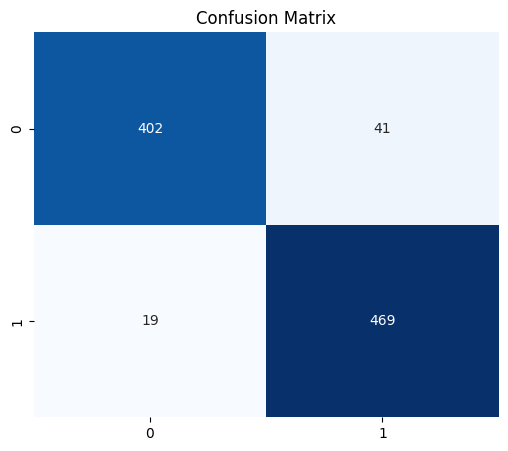

{'Precision': 0.9196078431372549,
 'Recall': 0.9610655737704918,
 'F1-Score': 0.9398797595190381,
 'Accuracy': 0.9355531686358755}

In [108]:
model = CustomLogistic(rate=0.01, n=1000)
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

Кастомный классификатор

metrics:
Precision: 0.9838056680161943
Recall: 0.9959016393442623
F1-Score: 0.9898167006109979
Accuracy: 0.9892588614393125


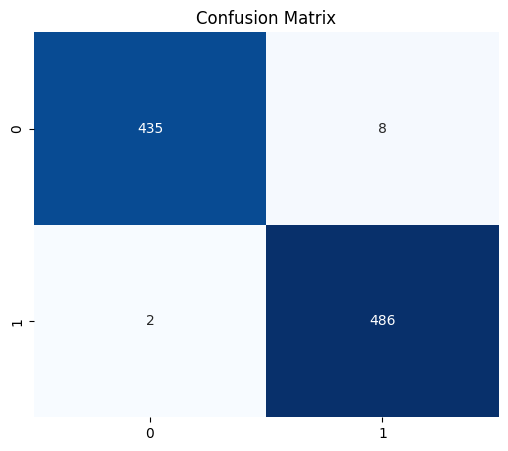

{'Precision': 0.9838056680161943,
 'Recall': 0.9959016393442623,
 'F1-Score': 0.9898167006109979,
 'Accuracy': 0.9892588614393125}

In [109]:
model = CustomClassifier(rate=0.01, n=1000)
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

SKLearn логистическая регрессия

metrics:
Precision: 0.9897959183673469
Recall: 0.9938524590163934
F1-Score: 0.9918200408997955
Accuracy: 0.99140708915145


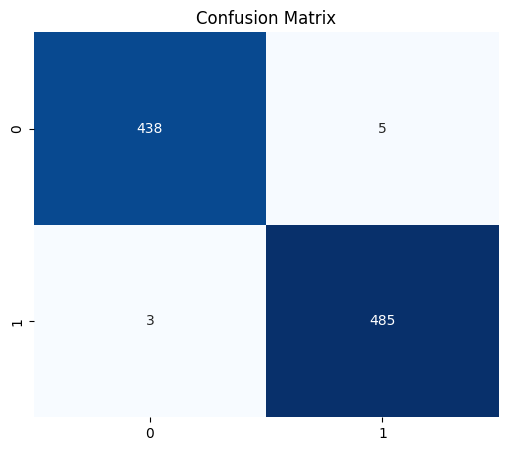

{'Precision': 0.9897959183673469,
 'Recall': 0.9938524590163934,
 'F1-Score': 0.9918200408997955,
 'Accuracy': 0.99140708915145}

In [110]:
model = LogisticRegression()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

SKLearn SVM

metrics:
Precision: 0.9877800407331976
Recall: 0.9938524590163934
F1-Score: 0.9908069458631257
Accuracy: 0.9903329752953813


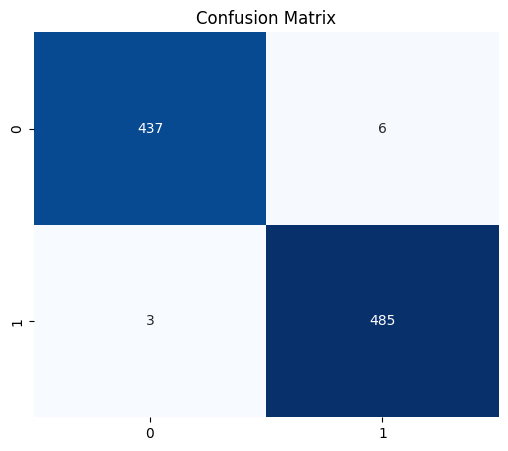

{'Precision': 0.9877800407331976,
 'Recall': 0.9938524590163934,
 'F1-Score': 0.9908069458631257,
 'Accuracy': 0.9903329752953813}

In [111]:
model = SVC()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

SKLearn Решающее дерево

metrics:
Precision: 0.9837728194726166
Recall: 0.9938524590163934
F1-Score: 0.9887869520897044
Accuracy: 0.9881847475832438


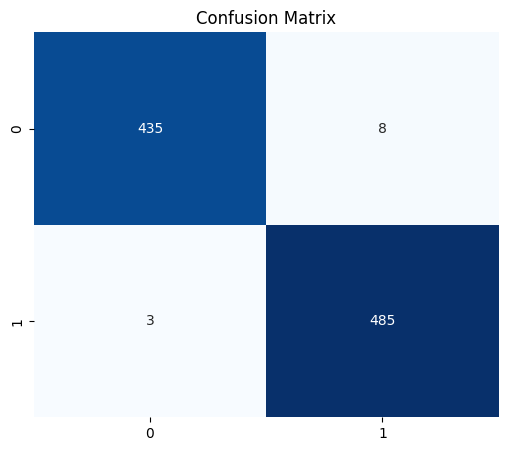

{'Precision': 0.9837728194726166,
 'Recall': 0.9938524590163934,
 'F1-Score': 0.9887869520897044,
 'Accuracy': 0.9881847475832438}

In [112]:
model = DecisionTreeClassifier()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

SKLearn Случайный лес

metrics:
Precision: 0.9817444219066938
Recall: 0.9918032786885246
F1-Score: 0.9867482161060143
Accuracy: 0.9860365198711063


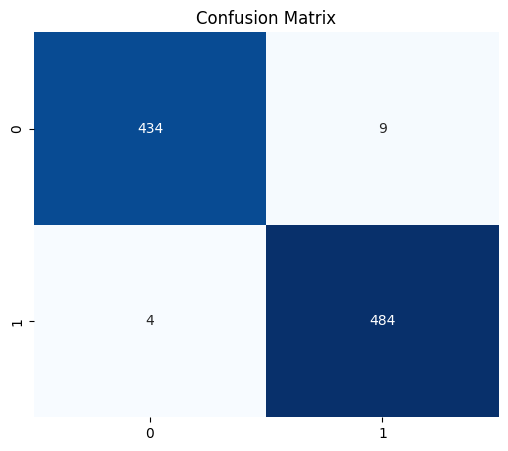

{'Precision': 0.9817444219066938,
 'Recall': 0.9918032786885246,
 'F1-Score': 0.9867482161060143,
 'Accuracy': 0.9860365198711063}

In [113]:
model = RandomForestClassifier()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

SKLearn Градиентный бустинг

metrics:
Precision: 0.9959016393442623
Recall: 0.9959016393442623
F1-Score: 0.9959016393442623
Accuracy: 0.9957035445757251


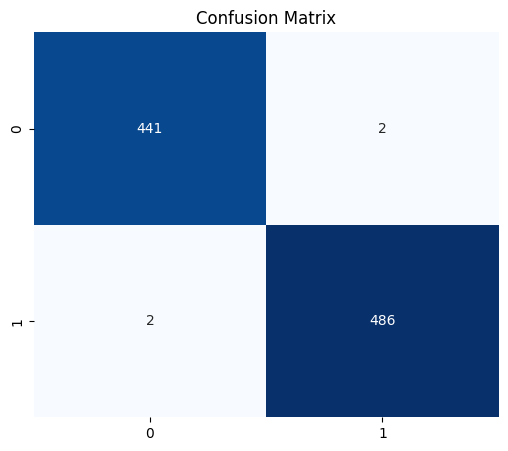

{'Precision': 0.9959016393442623,
 'Recall': 0.9959016393442623,
 'F1-Score': 0.9959016393442623,
 'Accuracy': 0.9957035445757251}

In [114]:
model = GradientBoostingClassifier()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
display_metrics(y_test, y_pred)

LightGBM Градиентный бустинг

[LightGBM] [Info] Number of positive: 4292, number of negative: 4086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3753
[LightGBM] [Info] Number of data points in the train set: 8378, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512294 -> initscore=0.049186
[LightGBM] [Info] Start training from score 0.049186
metrics:
Precision: 0.991869918699187
Recall: 1.0
F1-Score: 0.9959183673469387
Accuracy: 0.9957035445757251


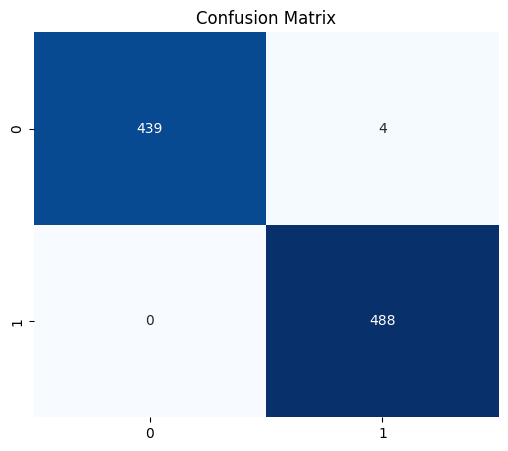

{'Precision': 0.991869918699187,
 'Recall': 1.0,
 'F1-Score': 0.9959183673469387,
 'Accuracy': 0.9957035445757251}

In [115]:
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
display_metrics(y_test, y_pred)

XGBoost Градиентный бустинг

metrics:
Precision: 0.9898580121703854
Recall: 1.0
F1-Score: 0.9949031600407747
Accuracy: 0.9946294307196563


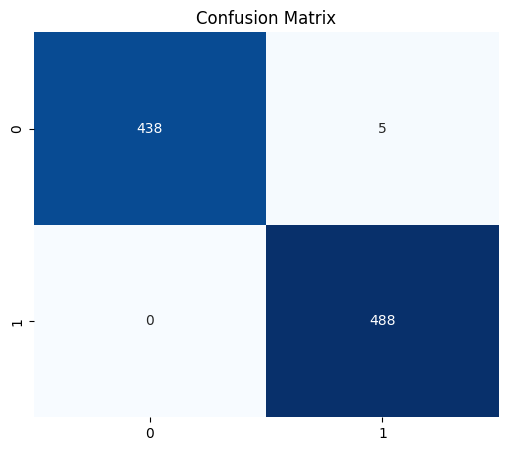

{'Precision': 0.9898580121703854,
 'Recall': 1.0,
 'F1-Score': 0.9949031600407747,
 'Accuracy': 0.9946294307196563}

In [116]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
display_metrics(y_test, y_pred)

CatBoost Градиентный бустинг

Learning rate set to 0.025534
0:	learn: 0.6441576	total: 5.58ms	remaining: 5.57s
1:	learn: 0.6027454	total: 12ms	remaining: 6.01s
2:	learn: 0.5662683	total: 22.5ms	remaining: 7.46s
3:	learn: 0.5250420	total: 28.8ms	remaining: 7.16s
4:	learn: 0.4910847	total: 35ms	remaining: 6.96s
5:	learn: 0.4616705	total: 42.5ms	remaining: 7.04s
6:	learn: 0.4298688	total: 48.7ms	remaining: 6.91s
7:	learn: 0.4113302	total: 54.3ms	remaining: 6.74s
8:	learn: 0.3799940	total: 59ms	remaining: 6.5s
9:	learn: 0.3588716	total: 63.1ms	remaining: 6.25s
10:	learn: 0.3328798	total: 68.5ms	remaining: 6.16s
11:	learn: 0.3116313	total: 73.9ms	remaining: 6.09s
12:	learn: 0.2961072	total: 78.9ms	remaining: 5.99s
13:	learn: 0.2792712	total: 83.2ms	remaining: 5.86s
14:	learn: 0.2578444	total: 88ms	remaining: 5.78s
15:	learn: 0.2377837	total: 92ms	remaining: 5.66s
16:	learn: 0.2233684	total: 96.3ms	remaining: 5.57s
17:	learn: 0.2068305	total: 101ms	remaining: 5.49s
18:	learn: 0.1966075	total: 106ms	remaining: 5.45s
19:	l

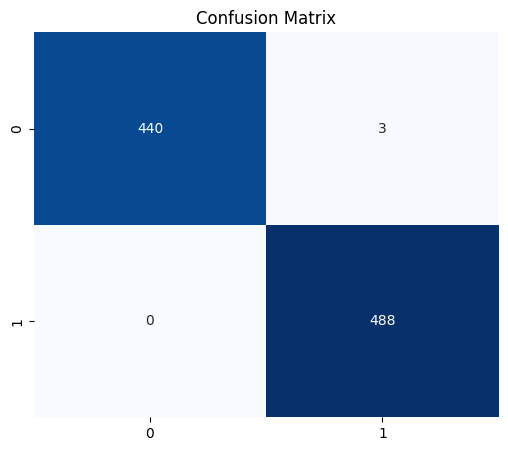

{'Precision': 0.9938900203665988,
 'Recall': 1.0,
 'F1-Score': 0.9969356486210419,
 'Accuracy': 0.9967776584317938}

In [117]:
model = CatBoostClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
display_metrics(y_test, y_pred)

Лучше всего себя показали CatBoost, LGB, XGB. Это понятно, потому что за CatBoost стоит Яндекс, за lightgbm стоит Microsoft, а XGB - это детище сообщества ml. Собственно, кастомные модели тоже оказались вполне неплохими, но, конечно, до библиотечных очень далеко. Помимо этого, хуже всего себя показали DecisionTree и RandomForest, потому что они легче могут переобучиться и также требуют более тонкой настройки параметров. Среди методов бустинга лучший результат получился при использовании CatBoost, потому что Яндекс крутая компания. 

Главными метриками оказались F1 и точность, потому что, например, recall начал с определенного момента равняться 1.0, поэтому по этой метрике особо не сравнишь модели. А после ознакомления с confusion matrix стало понятно, что модель работает довольно точно и редко ошибается.